In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#first pre trained model (VGG16)

In [ ]:
df = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/train.csv", index_col=0)
print(df.shape)
df.head()

(1821, 4)


healthy  multiple_diseases  rust  scab
image_id                                        
Train_0         0                  0     0     1
Train_1         0                  1     0     0
Train_2         1                  0     0     0
Train_3         0                  0     1     0
Train_4         1                  0     0     0

In [ ]:
from sklearn.model_selection import train_test_split

train_set, valid_set = train_test_split(df, test_size=0.2, random_state=42)

print(train_set.shape)
print(valid_set.shape)

(1456, 4)
(365, 4)


In [ ]:
import shutil
from shutil import copyfile

# delete temp dir
if os.path.exists('/kaggle/temp/'):
    shutil.rmtree('/kaggle/temp/')

os.mkdir('/kaggle/temp/')

# train directory
os.mkdir('/kaggle/temp/train')
os.mkdir('/kaggle/temp/train/healthy')
os.mkdir('/kaggle/temp/train/multiple_diseases')
os.mkdir('/kaggle/temp/train/rust')
os.mkdir('/kaggle/temp/train/scab')

# validation directory
os.mkdir('/kaggle/temp/valid')
os.mkdir('/kaggle/temp/valid/healthy')
os.mkdir('/kaggle/temp/valid/multiple_diseases')
os.mkdir('/kaggle/temp/valid/rust')
os.mkdir('/kaggle/temp/valid/scab')

In [ ]:
SOURCE = '/kaggle/input/plant-pathology-2020-fgvc7/images/'

TRAIN_DIR = '/kaggle/temp/train/'

# copy images to train directory
for index, data in train_set.iterrows():
    label = df.columns[np.argmax(data)]
    filepath = os.path.join(SOURCE, index + ".jpg")
    destination = os.path.join(TRAIN_DIR, label, index + ".jpg")
    copyfile(filepath, destination)

for subdir in os.listdir(TRAIN_DIR):
    print(subdir, len(os.listdir(os.path.join(TRAIN_DIR, subdir))))

healthy 416
scab 465
multiple_diseases 73
rust 502


In [ ]:
VALID_DIR = '/kaggle/temp/valid/'

# copy images to valid directory
for index, data in valid_set.iterrows():
    label = df.columns[np.argmax(data)]
    filepath = os.path.join(SOURCE, index + ".jpg")
    destination = os.path.join(VALID_DIR, label, index + ".jpg")
    copyfile(filepath, destination)

for subdir in os.listdir(VALID_DIR):
    print(subdir, len(os.listdir(os.path.join(VALID_DIR, subdir))))

healthy 100
scab 127
multiple_diseases 18
rust 120


In [ ]:
healthy_dir = os.path.join(TRAIN_DIR, 'healthy')
mdiseases_dir = os.path.join(TRAIN_DIR, 'multiple_diseases')
scab_dir = os.path.join(TRAIN_DIR, 'scab')
rust_dir = os.path.join(TRAIN_DIR, 'rust')

healthy_files = os.listdir(healthy_dir)
mdiseases_files = os.listdir(mdiseases_dir)
scab_files = os.listdir(scab_dir)
rust_files = os.listdir(rust_dir)

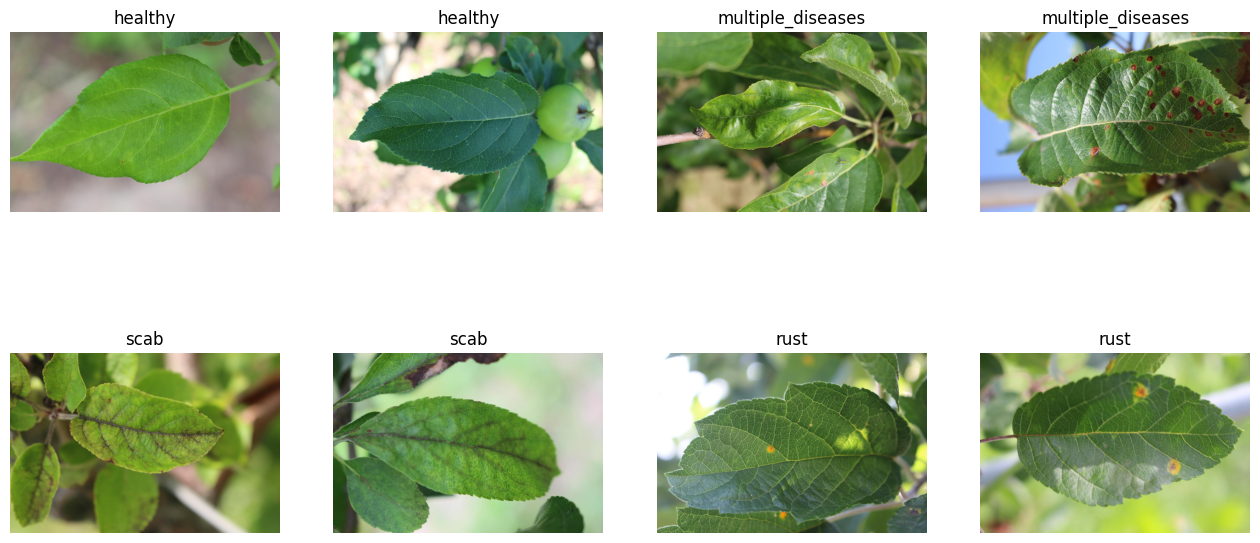

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_healthy = [os.path.join(healthy_dir, fname) for fname in healthy_files[pic_index-2:pic_index]]
next_mdiseases = [os.path.join(mdiseases_dir, fname) for fname in mdiseases_files[pic_index-2:pic_index]]
next_scab = [os.path.join(scab_dir, fname) for fname in scab_files[pic_index-2:pic_index]]
next_rust = [os.path.join(rust_dir, fname) for fname in rust_files[pic_index-2:pic_index]]


nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

for i, img_path in enumerate(next_healthy+next_mdiseases+next_scab+next_rust):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    plt.title(img_path.split('/')[-2])
    plt.imshow(img)

plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import os
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.layers as tfl
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from PIL import Image
import csv
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

training_datagen = ImageDataGenerator(rescale = 1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

#test_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = training_datagen.flow_from_directory(TRAIN_DIR, target_size=(150,150), class_mode='categorical', batch_size=32)
validation_generator = validation_datagen.flow_from_directory(VALID_DIR, target_size=(150,150), class_mode='categorical', batch_size=32)


Found 1456 images belonging to 4 classes.
Found 365 images belonging to 4 classes.


Import VGG16 Model

In [ ]:
# from tensorflow.keras.applications.vgg16 import VGG16

# base_model = VGG16(input_shape = (150, 150, 3), # Shape of our images
# include_top = False, # Leave out the last fully connected layer
# weights = 'imagenet')

In [ ]:
# import tensorflow as tf
# import keras
# from keras import layers
# for layer in base_model.layers:
#     layer.trainable = False
#     tf.keras.layers.BatchNormalization()

In [ ]:
# # Flatten the output layer to 1 dimension
# x = layers.Flatten()(base_model.output)

# # Add a fully connected layer with 512 hidden units and ReLU activation
# x = layers.Dense(512, activation='relu')(x)

# # Add a dropout rate of 0.5
# x = layers.Dropout(0.5)(x)

# # Add a final sigmoid layer with 1 node for classification output
# x = layers.Dense(4, activation='softmax')(x)

# model = tf.keras.models.Model(base_model.input, x)

# model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics = ['acc'])

# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5)
# checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("vgg16.h5", save_best_only=True)

In [ ]:
 #vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 10, epochs = 15, validation_steps=12, callbacks=[early_stopping_cb, checkpoint_cb])

Visualize train and validation accuracy

In [ ]:
# import matplotlib.pyplot as plt
# acc = vgghist.history['acc']
# val_acc = vgghist.history['val_acc']
# loss = vgghist.history['loss']
# val_loss = vgghist.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'r', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.legend(loc=0)
# plt.show()

Evatuation

In [ ]:
# model = tf.keras.models.load_model("vgg16.h5") # rollback to best model
# model.evaluate(validation_generator)

get test data

In [ ]:
#from keras_preprocessing import image

# test_set = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/test.csv", index_col=0)

# X_test = []
# for index, data in test_set.iterrows():
#     filepath = os.path.join(SOURCE, index + ".jpg")
#     img = image.load_img(filepath, target_size=(150, 150))
#     x = image.img_to_array(img)
#     x = np.expand_dims(x, axis=0)
#     X_test.append(x)

# X_test = np.vstack(X_test) / 255 # rescale images

predict the test data


In [ ]:
# y_pred = model.predict(X_test, batch_size=10)
# df_out = pd.concat([test_set.reset_index(), pd.DataFrame(y_pred, columns = train_generator.class_indices.keys())], axis=1).set_index("image_id")
# df_out.to_csv('submission.csv')
# df_out.head()

183/183 [==============================] - 7s 30ms/step


healthy  multiple_diseases      rust      scab
image_id                                                 
Test_0    0.106944           0.044960  0.239254  0.608842
Test_1    0.199255           0.047042  0.460560  0.293144
Test_2    0.014253           0.024624  0.089598  0.871525
Test_3    0.552810           0.033190  0.152912  0.261087
Test_4    0.187862           0.061119  0.353388  0.397631

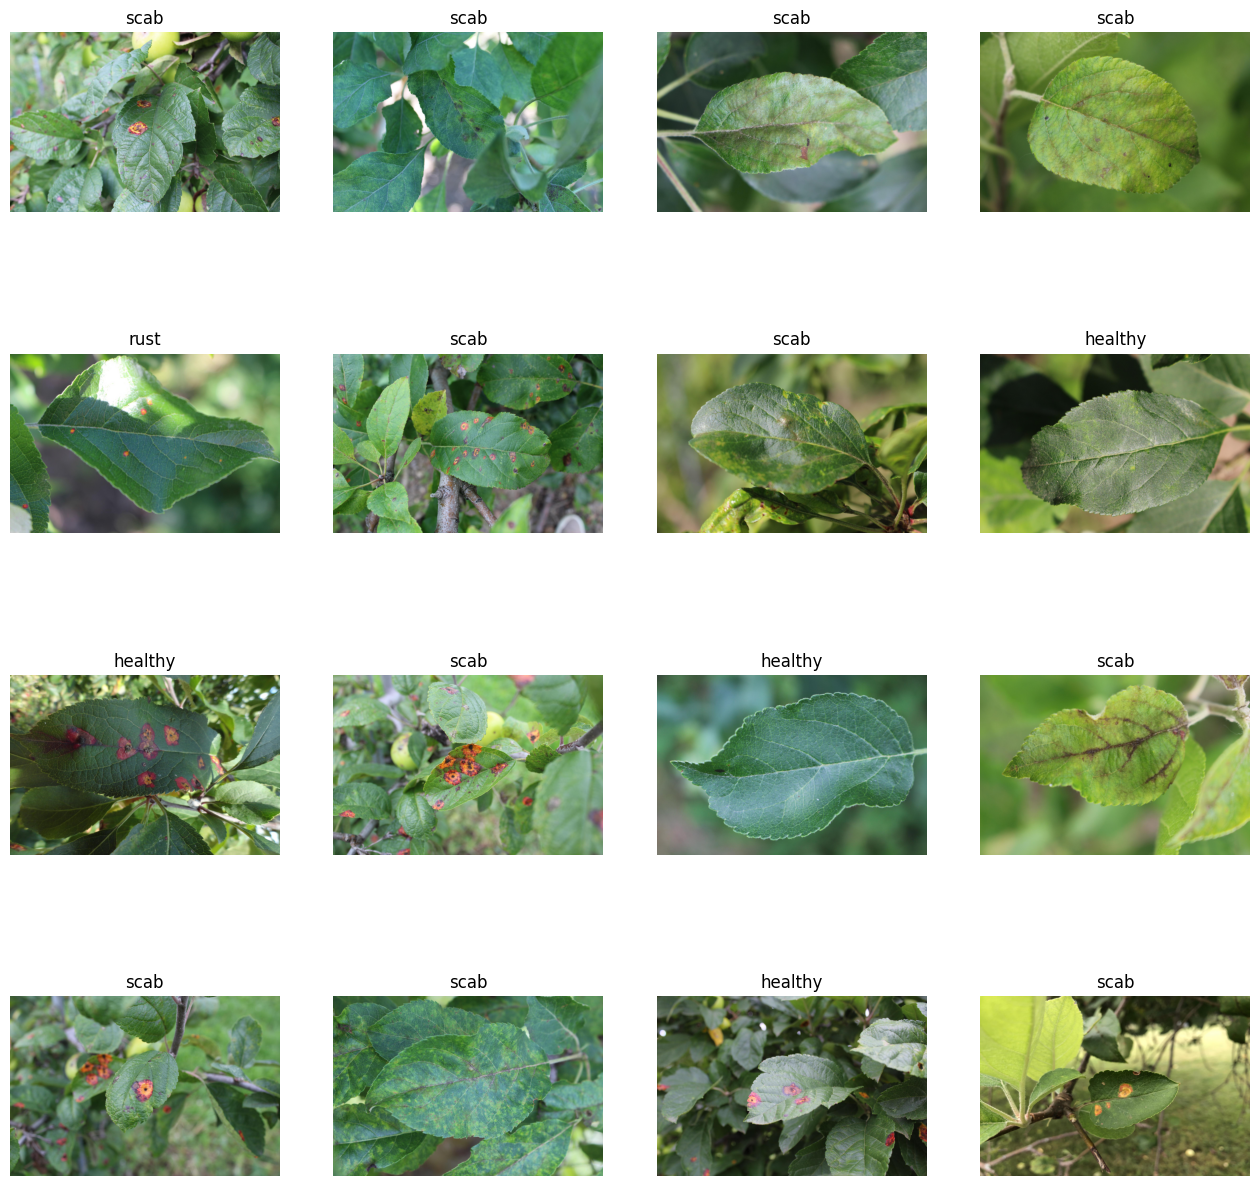

In [ ]:
# nrows = 4
# ncols = 4

# fig = plt.gcf()
# fig.set_size_inches(ncols*4, nrows*4)

# for i, (idx, row) in enumerate(df_out.sample(nrows*ncols).iterrows()):
#     filepath = filepath = os.path.join(SOURCE, idx + ".jpg")
#     sp = plt.subplot(nrows, ncols, i + 1)
#     sp.axis('Off') # Don't show axes (or gridlines)
#     img = mpimg.imread(filepath)
#     plt.title(df_out.columns[np.argmax(row)])
#     plt.imshow(img)

# plt.show()

Second model (Created model)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("cm.h5", save_best_only=True)

history = model.fit(train_generator, epochs=50, steps_per_epoch=46,
                    validation_data = validation_generator, validation_steps=12, callbacks=[early_stopping_cb, checkpoint_cb])

Epoch 1/50
46/46 [==============================] - 29s 594ms/step - loss: 0.6115 - accuracy: 0.7782 - val_loss: 0.4194 - val_accuracy: 0.8384
Epoch 2/50
46/46 [==============================] - 27s 589ms/step - loss: 0.5390 - accuracy: 0.8043 - val_loss: 0.3652 - val_accuracy: 0.8712
Epoch 3/50
46/46 [==============================] - 28s 606ms/step - loss: 0.5331 - accuracy: 0.8015 - val_loss: 0.5373 - val_accuracy: 0.7808
Epoch 4/50
46/46 [==============================] - 28s 606ms/step - loss: 0.5130 - accuracy: 0.8084 - val_loss: 0.5944 - val_accuracy: 0.7479
Epoch 5/50
46/46 [==============================] - 27s 597ms/step - loss: 0.4785 - accuracy: 0.8310 - val_loss: 0.3099 - val_accuracy: 0.8877
Epoch 6/50
46/46 [==============================] - 28s 609ms/step - loss: 0.5099 - accuracy: 0.8159 - val_loss: 0.5052 - val_accuracy: 0.7863
Epoch 7/50
46/46 [==============================] - 28s 611ms/step - loss: 0.5072 - accuracy: 0.8187 - val_loss: 0.3551 - val_accuracy: 0.8822

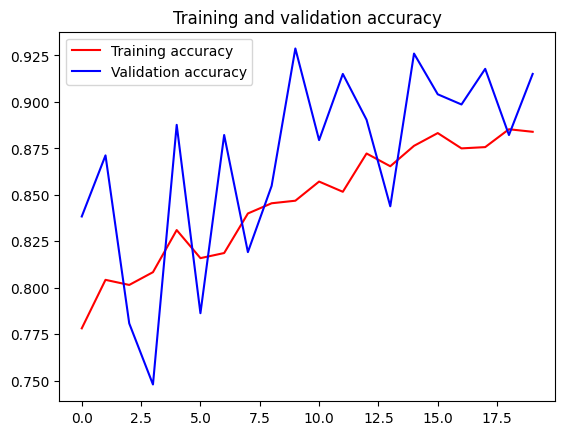

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

In [ ]:
model = tf.keras.models.load_model("cm.h5") # rollback to best model
model.evaluate(validation_generator)

12/12 [==============================] - 4s 337ms/step - loss: 0.2368 - accuracy: 0.9260


[0.2368302196264267, 0.9260274171829224]

In [ ]:
#from keras_preprocessing import image

test_set = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/test.csv", index_col=0)

X_test = []
for index, data in test_set.iterrows():
    filepath = os.path.join(SOURCE, index + ".jpg")
    img = image.load_img(filepath, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    X_test.append(x)

X_test = np.vstack(X_test) / 255 # rescale images

In [ ]:
y_pred = model.predict(X_test, batch_size=10)
df_out = pd.concat([test_set.reset_index(), pd.DataFrame(y_pred, columns = train_generator.class_indices.keys())], axis=1).set_index("image_id")
df_out.to_csv('submission.csv')
df_out.head()

183/183 [==============================] - 1s 4ms/step


healthy  multiple_diseases      rust          scab
image_id                                                         
Test_0    6.722297e-12           0.000572  0.999428  7.045307e-13
Test_1    1.999887e-08           0.015762  0.984238  1.652383e-08
Test_2    4.754157e-02           0.017981  0.000729  9.337487e-01
Test_3    8.150271e-01           0.023522  0.002990  1.584612e-01
Test_4    1.529118e-18           0.001206  0.998794  3.132368e-18

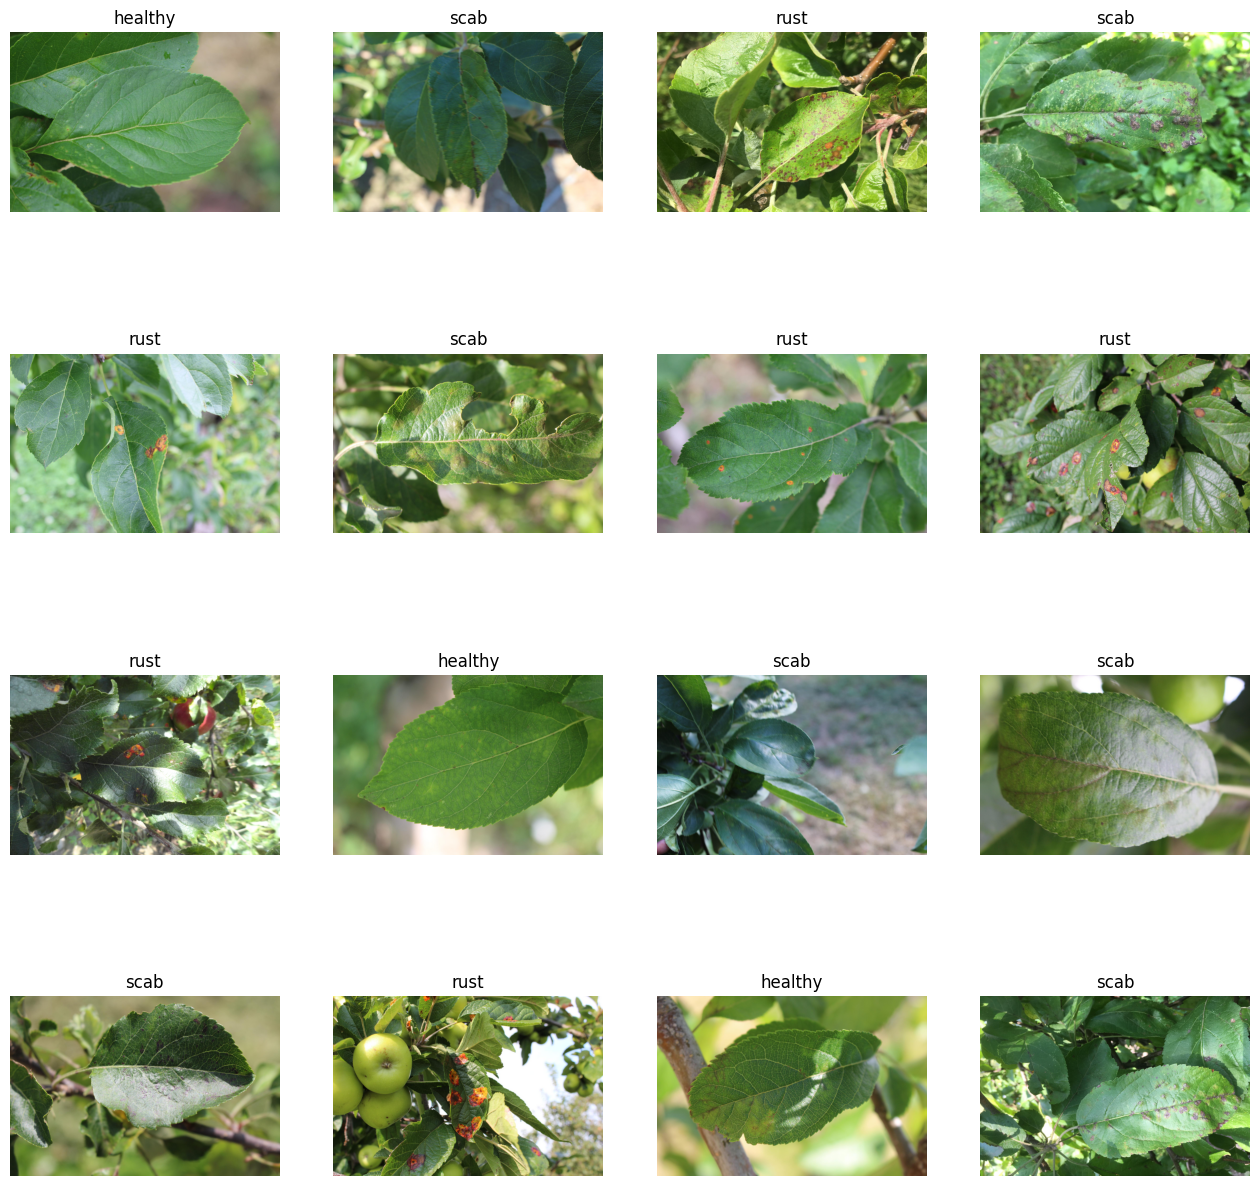

In [ ]:
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

for i, (idx, row) in enumerate(df_out.sample(nrows*ncols).iterrows()):
    filepath = filepath = os.path.join(SOURCE, idx + ".jpg")
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(filepath)
    plt.title(df_out.columns[np.argmax(row)])
    plt.imshow(img)

plt.show()

In [1]:
# import numpy as np
# import pandas as pd
# import streamlit as st
# import requests
# from PIL import Image
# from io import BytesIO
# import tensorflow as tf
# st.set_option('deprecation.showfileUploaderEncoding', False)
# import cv2
# from PIL import Image, ImageOps
# import numpy as np

# #physical_devices = tf.config.experimental.list_physical_devices('GPU')
# # if len(physical_devices) > 0:
# #    tf.config.experimental.set_memory_growth(physical_devices[0], True)


# if len(physical_devices) > 0:
#         tf.config.experimental.set_memory_growth(physical_devices[0], True)
# model = tf.keras.models.load_model('vgg.h5')


# st.write("""
#          # Plant Pathology
#          """
#          )

# st.write("This is a image classification web app to predict Plant Disease")



# file = st.file_uploader("Please upload an image file", type=["jpg", "png",'jpeg'])



# def import_and_predict(image_data, model):

#         size = (128,128)
#         image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
#         image = np.asarray(image)
#         img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         img_resize = (cv2.resize(img, dsize=(128, 128),    interpolation=cv2.INTER_CUBIC))/255.

#         img_reshape = img_resize[np.newaxis,...]

#         prediction = model.predict(img_reshape)

#         return prediction
# if file is None:
#     st.text("Please upload an image file")
# else:
#     image = Image.open(file)
#     st.image(image, use_column_width=True)
#     prediction = import_and_predict(image, model)

#     if np.argmax(prediction) == 0:
#         st.write("is Healthy!")
#     elif np.argmax(prediction) == 1:
#         st.write("has Multiple Diseases!")
#     elif np.argmax(prediction) == 2:
#         st.write("has Rust!")
#     else:
#         st.write("has Scab!")



#     st.write(prediction)



try some things in the same created model

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("cmv2.h5", save_best_only=True)

history = model.fit(train_generator, epochs=50, steps_per_epoch=46,
                    validation_data = validation_generator, validation_steps=12, callbacks=[early_stopping_cb, checkpoint_cb])

Epoch 1/50
46/46 [==============================] - 30s 611ms/step - loss: 1.2503 - accuracy: 0.3489 - val_loss: 1.2046 - val_accuracy: 0.3753
Epoch 2/50
46/46 [==============================] - 29s 625ms/step - loss: 1.2346 - accuracy: 0.3853 - val_loss: 1.1961 - val_accuracy: 0.4603
Epoch 3/50
46/46 [==============================] - 28s 608ms/step - loss: 1.1976 - accuracy: 0.4423 - val_loss: 1.1202 - val_accuracy: 0.5041
Epoch 4/50
46/46 [==============================] - 28s 612ms/step - loss: 1.0863 - accuracy: 0.5522 - val_loss: 0.9362 - val_accuracy: 0.6192
Epoch 5/50
46/46 [==============================] - 28s 613ms/step - loss: 0.9168 - accuracy: 0.6387 - val_loss: 0.8404 - val_accuracy: 0.6301
Epoch 6/50
46/46 [==============================] - 27s 587ms/step - loss: 0.7696 - accuracy: 0.6758 - val_loss: 0.6617 - val_accuracy: 0.7315
Epoch 7/50
46/46 [==============================] - 28s 610ms/step - loss: 0.7561 - accuracy: 0.6916 - val_loss: 0.5959 - val_accuracy: 0.7562

In [ ]:
model = tf.keras.models.load_model("cmv2.h5") # rollback to best model
model.evaluate(validation_generator)

12/12 [==============================] - 4s 328ms/step - loss: 0.3240 - accuracy: 0.8849


[0.32396966218948364, 0.8849315047264099]

In [ ]:
test_set = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/test.csv", index_col=0)

X_test = []
for index, data in test_set.iterrows():
    filepath = os.path.join(SOURCE, index + ".jpg")
    img = image.load_img(filepath, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    X_test.append(x)

X_test = np.vstack(X_test) / 255 # rescale images

In [ ]:
y_pred = model.predict(X_test, batch_size=10)
df_out = pd.concat([test_set.reset_index(), pd.DataFrame(y_pred, columns = train_generator.class_indices.keys())], axis=1).set_index("image_id")
df_out.to_csv('submission2.csv')
df_out.head()

183/183 [==============================] - 1s 4ms/step


healthy  multiple_diseases      rust          scab
image_id                                                         
Test_0    1.419845e-10           0.009568  0.990432  5.207385e-09
Test_1    4.344734e-09           0.006854  0.993145  6.937398e-07
Test_2    7.088266e-02           0.011997  0.000758  9.163616e-01
Test_3    6.523574e-01           0.015166  0.002429  3.300475e-01
Test_4    7.856536e-24           0.000181  0.999819  2.340358e-19

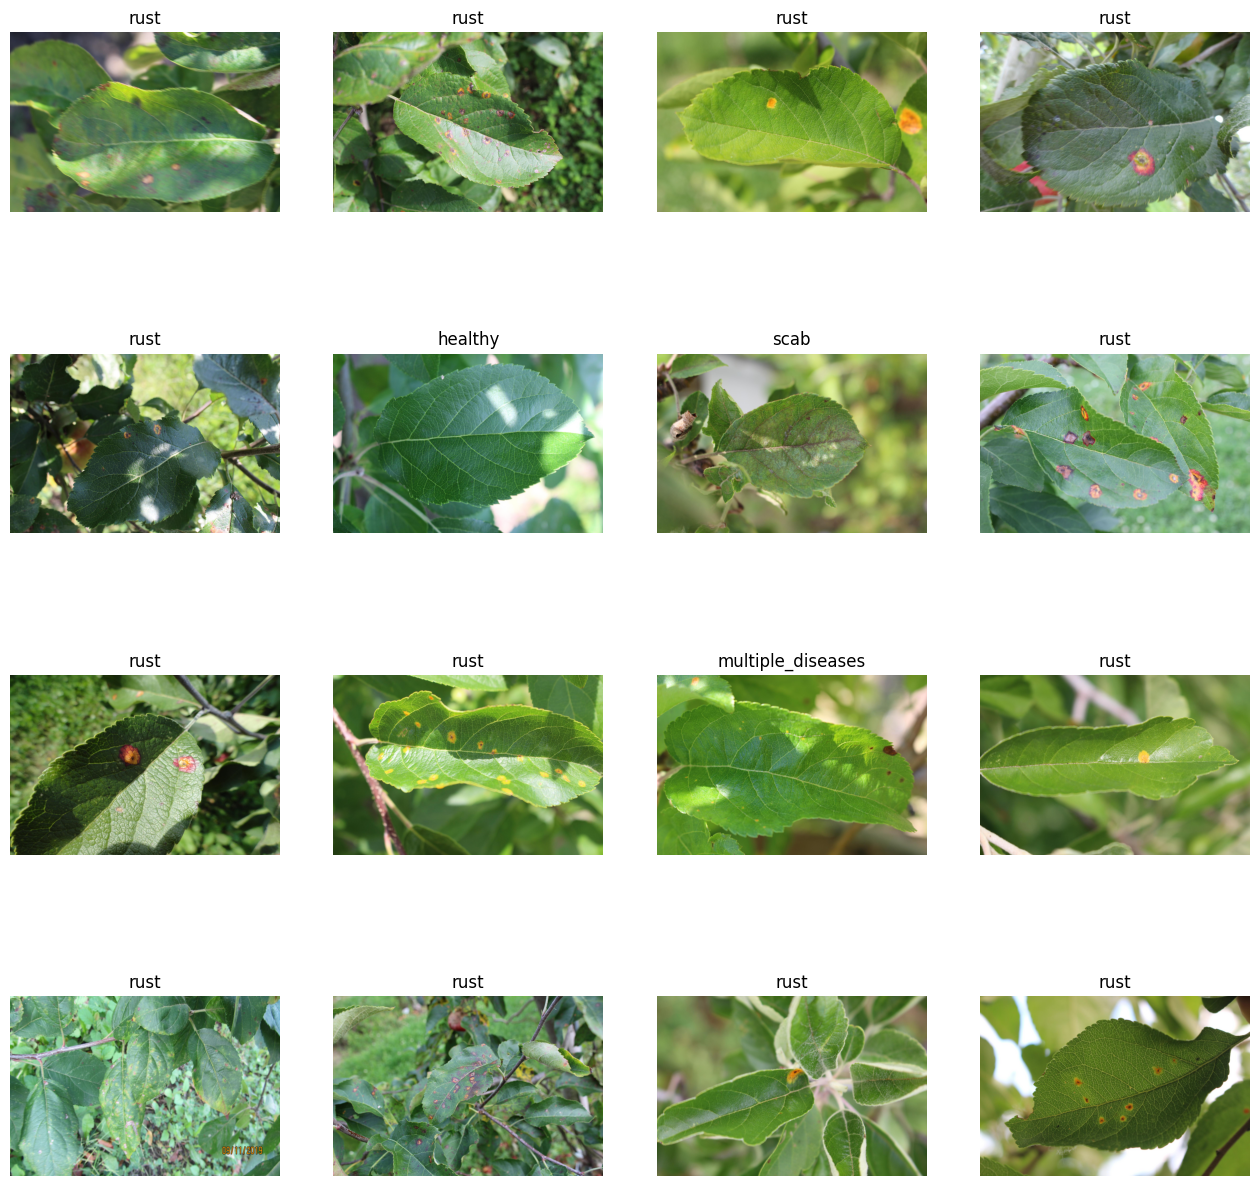

In [ ]:
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

for i, (idx, row) in enumerate(df_out.sample(nrows*ncols).iterrows()):
    filepath = filepath = os.path.join(SOURCE, idx + ".jpg")
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(filepath)
    plt.title(df_out.columns[np.argmax(row)])
    plt.imshow(img)

plt.show()

#Dense Net Model with balance data (the best model and heighest accuracy)


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import shutil
import random

import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201

import cv2

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_df = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/train.csv")
train_df['img_name'] = train_df['image_id'] + ".jpg"
train_df.head()

image_id  healthy  multiple_diseases  rust  scab     img_name
0  Train_0        0                  0     0     1  Train_0.jpg
1  Train_1        0                  1     0     0  Train_1.jpg
2  Train_2        1                  0     0     0  Train_2.jpg
3  Train_3        0                  0     1     0  Train_3.jpg
4  Train_4        1                  0     0     0  Train_4.jpg

In [ ]:
target_multi_cols = ['healthy', 'multiple_diseases', 'rust', 'scab']

print("Multi Classification Targets")
print(train_df[target_multi_cols].sum())

Multi Classification Targets
healthy              516
multiple_diseases     91
rust                 622
scab                 592
dtype: int64


Maka data balance (over sampling)

In [ ]:
def balance_set(df, x_cols, y_cols):
    ros = RandomOverSampler(random_state=42)

    x_multi, y_multi = ros.fit_resample(df[x_cols], df[y_cols].values)
    data = pd.concat([x_multi, pd.DataFrame(y_multi, columns= y_cols)], axis=1)
    return data

train_multi = balance_set(train_df,
                          x_cols = ["image_id", "img_name"],
                          y_cols = target_multi_cols)


labels = train_multi[target_multi_cols]
label_names = labels[labels==1].stack().reset_index()['level_1']
label_names.index = train_multi.index
train_multi['label_names'] = label_names

print("Multi Classification Labels")
print(train_multi[target_multi_cols].sum())

Multi Classification Labels
healthy              622
multiple_diseases    622
rust                 622
scab                 622
dtype: int64


make blur to image (to improve accuracy) and make image generator

In [ ]:
def blur_preprocessing(img):
    return cv2.blur(img, (5, 5))

tf.random.set_seed(99)
img_data_generator = ImageDataGenerator(rescale=1/255,
                                        validation_split=0.2,
                                        rotation_range = 180,
                                        horizontal_flip = True,
                                        vertical_flip = True,
                                        preprocessing_function=blur_preprocessing
                                       )


train_data_multi = img_data_generator.flow_from_dataframe(dataframe=train_multi,
                                                    directory="/kaggle/input/plant-pathology-2020-fgvc7/images/",
                                                    x_col="img_name",
                                                    y_col= "label_names",
                                                    target_size=(256, 256),
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    subset='training',
                                                    shuffle=True,
                                                    seed=42)

val_data_multi = img_data_generator.flow_from_dataframe(dataframe=train_multi,
                                                    directory="/kaggle/input/plant-pathology-2020-fgvc7/images/",
                                                    x_col="img_name",
                                                    y_col="label_names",
                                                    target_size=(256, 256),
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    subset='validation',
                                                    shuffle=True,
                                                    seed=42)

Found 1991 validated image filenames belonging to 4 classes.
Found 497 validated image filenames belonging to 4 classes.


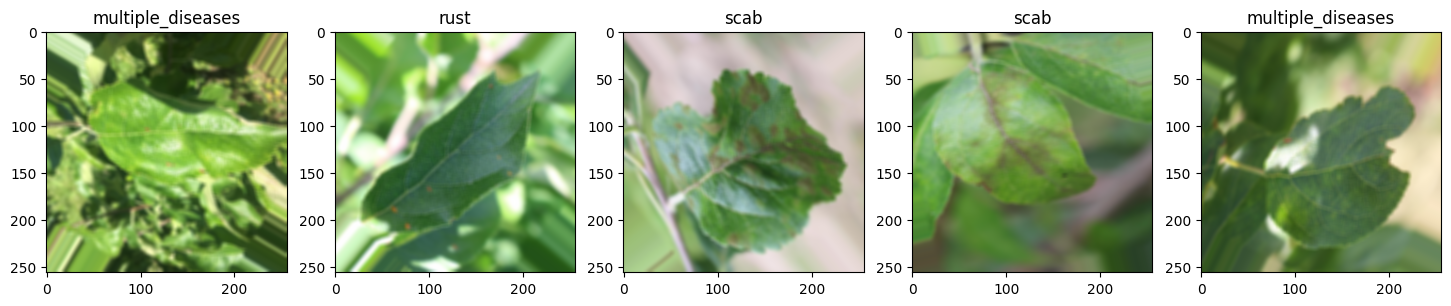

In [ ]:
def show_imgs(df, num):
    fig, ax = plt.subplots(1,num, figsize=(18,9))
    for x, y in df:
        for img in range(num):
            ax[img].imshow(x[img])
            if y[img][0]:
                title="healthy"
            elif y[img][1]:
                title='multiple_diseases'
            elif y[img][2]:
                title='rust'
            elif y[img][3] :
                title='scab'
            ax[img].set_title(title)
        break
show_imgs(train_data_multi, 5)

In [ ]:
learning_rate_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0003,
                                                                         decay_steps=2,
                                                                         decay_rate=0.97,
                                                                         staircase=False)

In [ ]:
def dense_net_model(trainable_weights=False, weights_path=None):

    tf.keras.backend.clear_session()

    dense_net = DenseNet201(input_shape=(256, 256, 3), weights="imagenet", include_top=False)

    for layer in dense_net.layers:
        layer.trainable=trainable_weights

    model = tf.keras.models.Sequential([dense_net,
                                        tf.keras.layers.GlobalAveragePooling2D(),
                                        tf.keras.layers.Dense(128, activation='relu'),
                                        tf.keras.layers.Dropout(0.3),
                                        tf.keras.layers.Dense(4, activation='softmax')])

    if weights_path:
        model.load_weights(weights_path)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

    return model

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("dense.h5", save_best_only=True)

dense_net_transfer = dense_net_model(trainable_weights=True)

dense_net_transfer_history = dense_net_transfer.fit(train_data_multi, validation_data=val_data_multi, epochs=25, steps_per_epoch=32, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/25
32/32 [==============================] - 218s 2s/step - loss: 0.6594 - accuracy: 0.7178 - val_loss: 1.6250 - val_accuracy: 0.4024
Epoch 2/25
32/32 [==============================] - 57s 2s/step - loss: 0.2936 - accuracy: 0.8959 - val_loss: 0.4921 - val_accuracy: 0.8330
Epoch 3/25
32/32 [==============================] - 51s 2s/step - loss: 0.2444 - accuracy: 0.9039 - val_loss: 0.3590 - val_accuracy: 0.8692
Epoch 4/25
32/32 [==============================] - 54s 2s/step - loss: 0.1365 - accuracy: 0.9521 - val_loss: 0.3204 - val_accuracy: 0.8893
Epoch 5/25
32/32 [==============================] - 52s 2s/step - loss: 0.0981 - accuracy: 0.9697 - val_loss: 0.2020 - val_accuracy: 0.9396
Epoch 6/25
32/32 [==============================] - 53s 2s/step - loss: 0.0956 - accuracy: 0.9717 - val_loss: 0.1788 - val_accuracy: 0.9497
Epoch 7/25
32/32 [==============================] - 53s 2s/step - loss: 0.0914 - accuracy: 0.9710 - val_loss: 0.1631 - val_accuracy: 0.9557
Epoch 8/25
32/32 [=

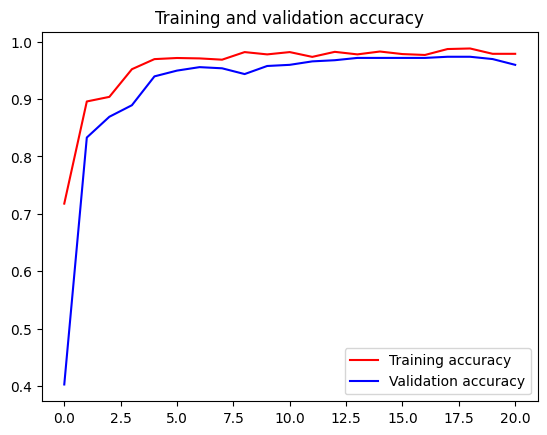

In [ ]:
import matplotlib.pyplot as plt
acc = dense_net_transfer_history.history['accuracy']
val_acc = dense_net_transfer_history.history['val_accuracy']
loss = dense_net_transfer_history.history['loss']
val_loss = dense_net_transfer_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

In [ ]:
#model = tf.keras.models.load_model("dense.h5") # rollback to best model
dense_net_transfer.evaluate(val_data_multi)

16/16 [==============================] - 14s 837ms/step - loss: 0.0915 - accuracy: 0.9678


[0.09147188812494278, 0.9678068161010742]

In [ ]:
test_df = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/test.csv")
test_df['img_name'] = test_df['image_id'] + ".jpg"

test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  directory="/kaggle/input/plant-pathology-2020-fgvc7/images/",
                                                  x_col="img_name",
                                                  y_col=None,
                                                  target_size=(256, 256),
                                                  class_mode=None,
                                                  batch_size=3,
                                                  shuffle=False,
                                                  seed=42)

test_generator.reset()

Found 1821 validated image filenames.


In [ ]:
preds = dense_net_transfer.predict_generator(test_generator, verbose=1, steps=607)

preds_df = pd.DataFrame(preds, columns=["healthy", "multiple_diseases", "rust", "scab"])

submission = pd.concat([test_df.image_id, preds_df], axis=1)

submission.head()

607/607 [==============================] - 46s 67ms/step


image_id   healthy  multiple_diseases      rust      scab
0   Test_0  0.000111           0.002933  0.996945  0.000011
1   Test_1  0.000018           0.001202  0.998775  0.000004
2   Test_2  0.177084           0.414771  0.087757  0.320388
3   Test_3  0.999806           0.000059  0.000040  0.000095
4   Test_4  0.000008           0.000232  0.999758  0.000002

In [ ]:
submission.to_csv("submission_DenseNet.csv", index=False)

In [ ]:
den_model = tf.keras.models.load_model("dense.h5") # rollback to best model
den_model.evaluate(val_data_multi)

16/16 [==============================] - 17s 826ms/step - loss: 0.0863 - accuracy: 0.9799


[0.08627106249332428, 0.9798792600631714]